<a href="https://colab.research.google.com/github/vinivel/PortfolioAlgGen/blob/main/portfolio_genetic_15_11A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

O código atual implementa um fluxo completo para otimizar portfólios e comparar diferentes estratégias, utilizando dados do mercado financeiro brasileiro.

1. Download e Preparação dos Dados
Bibliotecas Utilizadas: yfinance para obter cotações, pandas para manipulação de dados, e numpy para cálculos.
Passos:
Baixa cotações de 27 ações brasileiras (B3) para um período de 2 anos.
Remove colunas com valores nulos para garantir dados limpos.
Divide os dados em dois períodos: um de treinamento e outro de teste.

2. Algoritmo Genético
Ideia:
Simula um processo evolucionário para encontrar a melhor alocação de ativos.
Seleciona aleatoriamente 10 ativos para cada iteração e distribui pesos aleatórios normalizados.
Avalia o portfólio pelo Sharpe Ratio (relação entre retorno e risco).
Retém os pesos do portfólio com maior Sharpe Ratio entre 1000 iterações.

3. Método de Markowitz
Similar ao Algoritmo Genético:
Seleciona aleatoriamente ativos e distribui pesos.
Avalia cada portfólio pelo Sharpe Ratio.
Retém o melhor portfólio após 1000 iterações.

4. Cálculo de Desempenho
Estratégias:
Calcula retornos acumulados no período de teste para os dois portfólios otimizados e o índice Ibovespa.

Resultados:
Cria um DataFrame comparando os retornos acumulados.
Gera gráficos e salva os resultados em arquivos CSV.
Pontos de Atenção
Seleção de ativos é fixa e arbitrária.
Apenas uma divisão de treino/teste é realizada.
Uso de métodos iterativos pode ser ineficiente.

Successfully downloaded ABEV3.SA
Successfully downloaded B3SA3.SA
Successfully downloaded BBSE3.SA
Successfully downloaded BBDC4.SA
Successfully downloaded BBAS3.SA
Successfully downloaded BPAC11.SA
Successfully downloaded CMIG4.SA
Successfully downloaded ELET3.SA
Successfully downloaded EMBR3.SA
Successfully downloaded ENEV3.SA
Successfully downloaded EQTL3.SA
Successfully downloaded GGBR4.SA
Successfully downloaded ITSA4.SA
Successfully downloaded ITUB4.SA
Successfully downloaded JBSS3.SA
Successfully downloaded RENT3.SA
Successfully downloaded PETR3.SA
Successfully downloaded PRIO3.SA
Successfully downloaded RADL3.SA
Successfully downloaded RDOR3.SA
Successfully downloaded RAIL3.SA
Successfully downloaded SBSP3.SA
Successfully downloaded SUZB3.SA
Successfully downloaded UGPA3.SA
Successfully downloaded VALE3.SA
Successfully downloaded VBBR3.SA
Successfully downloaded WEGE3.SA

Shape of training data: (251, 27)
Shape of test data: (251, 27)
Optimizing portfolio using Genetic Algorith

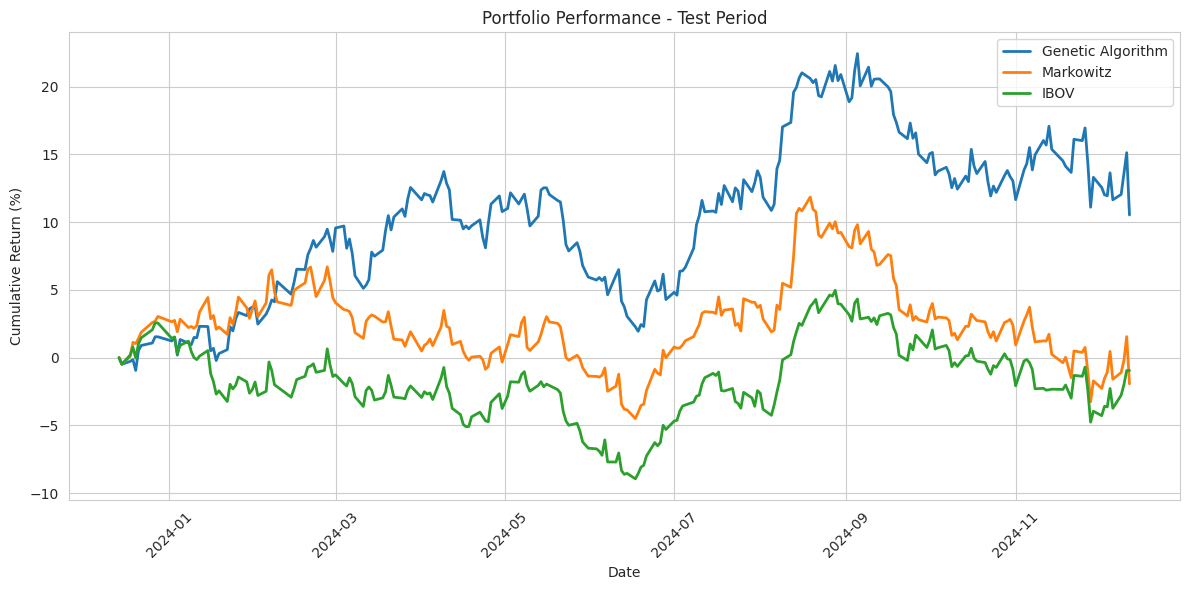


Calculating portfolio weights...

=== Portfolio Compositions (>0.1%) ===
          Genetic Algorithm (%)  Markowitz (%)
BBSE3.SA                   0.00           5.96
BBAS3.SA                   0.13          16.70
CMIG4.SA                   2.41           0.00
EMBR3.SA                  17.85           0.00
ENEV3.SA                   0.27           0.00
EQTL3.SA                   0.00          12.49
ITSA4.SA                   0.00           4.99
ITUB4.SA                   0.00           7.14
JBSS3.SA                   0.00          13.60
PETR3.SA                  16.51          11.29
PRIO3.SA                   0.00           4.92
RADL3.SA                  10.69           3.39
SBSP3.SA                  10.87           0.00
UGPA3.SA                  22.75          19.52
VALE3.SA                   3.92           0.00
VBBR3.SA                  14.60           0.00

Calculating performance metrics...

=== Performance Metrics ===
            Strategy                                   Total R

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_portfolio_performance(weights, prices):
    """Calcula o retorno acumulado de um portfólio em percentual"""
    returns = prices.pct_change().fillna(0)
    portfolio_returns = (returns * weights).sum(axis=1)
    cumulative_returns = (1 + portfolio_returns).cumprod()
    # Converter para variação percentual (descontando valor original)
    return (cumulative_returns - 1) * 100

def calculate_benchmark_performance(test_data):
    """Calcula o retorno do Ibovespa no período de teste em percentual"""
    try:
        ibov = yf.download('^BVSP',
                          start=test_data.index[0],
                          end=test_data.index[-1],
                          progress=False)['Close']

        ibov_returns = ibov.pct_change().fillna(0)
        ibov_performance = (1 + ibov_returns).cumprod()
        # Converter para variação percentual (descontando valor original)
        return (ibov_performance.reindex(test_data.index).ffill() - 1) * 100
    except Exception as e:
        print(f"Erro ao baixar dados do Ibovespa: {e}")
        return pd.Series(0.0, index=test_data.index)

def download_and_prepare_data():
    stocks = ['ABEV3.SA', 'B3SA3.SA', 'BBSE3.SA', 'BBDC4.SA', 'BBAS3.SA',
              'BPAC11.SA', 'CMIG4.SA', 'ELET3.SA', 'EMBR3.SA', 'ENEV3.SA',
              'EQTL3.SA', 'GGBR4.SA', 'ITSA4.SA', 'ITUB4.SA', 'JBSS3.SA',
              'RENT3.SA', 'PETR3.SA', 'PRIO3.SA', 'RADL3.SA', 'RDOR3.SA',
              'RAIL3.SA', 'SBSP3.SA', 'SUZB3.SA', 'UGPA3.SA', 'VALE3.SA',
              'VBBR3.SA', 'WEGE3.SA']

    end_date = datetime.now()
    start_date = end_date - timedelta(days=730)  # 24 meses

    print("Downloading stock data...")
    df_closing_prices = pd.DataFrame()
    for symbol in stocks:
        try:
            stock_data = yf.download(symbol, start=start_date, end=end_date, progress=False)
            if not stock_data.empty:
                df_closing_prices[symbol] = stock_data['Close']
                print(f"Successfully downloaded {symbol}")
        except Exception as e:
            print(f"Error downloading {symbol}: {str(e)}")

    df_closing_prices = df_closing_prices.dropna(axis=1)

    # Dividir em períodos de treinamento e teste
    split_date = df_closing_prices.index[len(df_closing_prices)//2]
    train_data = df_closing_prices[:split_date]
    test_data = df_closing_prices[split_date:]

    return train_data, test_data

def optimize_portfolio_genetic(returns, n_assets=10):
    """Otimização por algoritmo genético simplificado"""
    n_total = returns.shape[1]
    best_sharpe = -np.inf
    best_weights = None

    print("Optimizing portfolio using Genetic Algorithm...")
    for i in range(1000):
        if i % 100 == 0:
            print(f"Iteration {i}/1000")

        selected_assets = np.random.choice(n_total, n_assets, replace=False)
        weights = np.zeros(n_total)
        random_weights = np.random.random(n_assets)
        weights[selected_assets] = random_weights / random_weights.sum()

        portfolio_return = np.sum(returns.mean() * weights) * 252
        portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
        sharpe_ratio = portfolio_return / portfolio_risk if portfolio_risk != 0 else -np.inf

        if sharpe_ratio > best_sharpe:
            best_sharpe = sharpe_ratio
            best_weights = weights

    return best_weights

def optimize_portfolio_markowitz(returns, n_assets=10):
    """Otimização por Markowitz simplificada"""
    n_total = returns.shape[1]
    best_sharpe = -np.inf
    best_weights = None

    print("Optimizing portfolio using Markowitz approach...")
    for i in range(1000):
        if i % 100 == 0:
            print(f"Iteration {i}/1000")

        selected_assets = np.random.choice(n_total, n_assets, replace=False)
        weights = np.zeros(n_total)
        random_weights = np.random.random(n_assets)
        weights[selected_assets] = random_weights / random_weights.sum()

        portfolio_return = np.sum(returns.mean() * weights) * 252
        portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
        sharpe_ratio = portfolio_return / portfolio_risk if portfolio_risk != 0 else -np.inf

        if sharpe_ratio > best_sharpe:
            best_sharpe = sharpe_ratio
            best_weights = weights

    return best_weights

def main():
    # Download e preparação dos dados
    print("Downloading and preparing data...")
    train_data, test_data = download_and_prepare_data()

    print("\nShape of training data:", train_data.shape)
    print("Shape of test data:", test_data.shape)

    # Calcular retornos para o período de treinamento
    train_returns = train_data.pct_change().dropna()

    # Otimização dos portfólios
    genetic_weights = optimize_portfolio_genetic(train_returns)
    markowitz_weights = optimize_portfolio_markowitz(train_returns)

    print("\nCalculating portfolio performances...")
    # Calcular desempenho no período de teste
    genetic_performance = calculate_portfolio_performance(genetic_weights, test_data)
    markowitz_performance = calculate_portfolio_performance(markowitz_weights, test_data)
    benchmark_performance = calculate_benchmark_performance(test_data)

    print("\nCreating performance DataFrame...")
    # Criar DataFrame com os desempenhos
    performance_df = pd.DataFrame(index=test_data.index)
    performance_df['Genetic Algorithm'] = genetic_performance
    performance_df['Markowitz'] = markowitz_performance
    performance_df['IBOV'] = benchmark_performance

    print("\nPerformance DataFrame head:")
    print(performance_df.head())
    print("\nPerformance DataFrame shape:", performance_df.shape)

    print("\nPlotting results...")
    # Plotar resultados
    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid")

    for column in performance_df.columns:
        plt.plot(performance_df.index, performance_df[column],
                label=column, linewidth=2)

    plt.title('Portfolio Performance - Test Period')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return (%)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()

    print("\nSaving plot...")
    plt.savefig('portfolio_performance.png')
    plt.show()

    print("\nCalculating portfolio weights...")
    # Exibir composição dos portfólios
    portfolio_weights = pd.DataFrame({
        'Genetic Algorithm (%)': genetic_weights * 100,
        'Markowitz (%)': markowitz_weights * 100
    }, index=train_returns.columns)

    significant_positions = portfolio_weights[
        (portfolio_weights['Genetic Algorithm (%)'] > 0.1) |
        (portfolio_weights['Markowitz (%)'] > 0.1)
    ].round(2)

    print("\n=== Portfolio Compositions (>0.1%) ===")
    print(significant_positions)

    print("\nCalculating performance metrics...")
    # Calcular métricas de desempenho
    final_returns = pd.DataFrame({
        'Strategy': ['Genetic Algorithm', 'Markowitz', 'IBOV'],
        'Total Return (%)': [
            genetic_performance.iloc[-1],
            markowitz_performance.iloc[-1],
            benchmark_performance.iloc[-1]
        ]
    })

    print("\n=== Performance Metrics ===")
    print(final_returns.round(2))

    # Salvar resultados em arquivos
    print("\nSaving results to CSV files...")
    performance_df.to_csv('portfolio_performance.csv')
    significant_positions.to_csv('portfolio_compositions.csv')
    final_returns.to_csv('performance_metrics.csv')

    print("\nDone! All results have been saved.")

if __name__ == "__main__":
    np.random.seed(42)
    main()

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.covariance import LedoitWolf
from scipy.optimize import minimize

def download_and_prepare_data():
    """Baixa os dados dos ativos financeiros e prepara para análise."""
    try:
        # Baixar dados do IBOV e das ações (exemplo com PETR4 e ITUB4)
        assets = ['^BVSP', 'PETR4.SA', 'ITUB4.SA']
        data = yf.download(assets, start='2020-01-01', end='2023-12-31', progress=False)['Adj Close']

        # Dividir os dados em treino e teste
        train_data = data[:int(0.8*len(data))]
        test_data = data[int(0.8*len(data)):]

        return train_data, test_data
    except Exception as e:
        print(f"Erro ao baixar ou preparar dados: {e}")
        return None, None

def calculate_benchmark_performance(test_data):
    """Calcula o retorno do Ibovespa no período de teste em percentual"""
    try:
        ibov = yf.download('^BVSP',
                          start=test_data.index[0],
                          end=test_data.index[-1],
                          progress=False)['Close']

        ibov_returns = ibov.pct_change().fillna(0)
        ibov_performance = (1 + ibov_returns).cumprod()
        # Converter para variação percentual (descontando valor original)
        return (ibov_performance.reindex(test_data.index).ffill() - 1) * 100, ibov
    except Exception as e:
        print(f"Erro ao baixar dados do Ibovespa: {e}")
        return pd.Series(0.0, index=test_data.index), None

def optimize_portfolio_genetic(returns_data):
    """Otimiza o portfólio usando um algoritmo genético"""
    # Definindo o número de ativos
    num_assets = returns_data.shape[1]

    # Função de avaliação (fitness) do portfólio
    def fitness(weights):
        weights = np.array(weights)
        portfolio_return = np.sum(returns_data.mean() * weights)
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns_data.cov(), weights)))
        return -portfolio_return / portfolio_volatility  # Maximizar o retorno ajustado ao risco

    # Restrições e limites para as variáveis
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
    bounds = tuple((0, 1) for asset in range(num_assets))

    # Inicialização aleatória dos pesos
    initial_weights = num_assets * [1. / num_assets]

    # Minimizando a função de fitness (negativa)
    result = minimize(fitness, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)

    return result.x

def optimize_portfolio_markowitz(returns_data):
    """Otimiza o portfólio usando a abordagem de Markowitz"""
    # Calcula a matriz de covariância e o vetor de retornos esperados
    cov_matrix = returns_data.cov()
    expected_returns = returns_data.mean()

    # Restrições e limites para as variáveis
    num_assets = len(expected_returns)
    bounds = tuple((0, 1) for asset in range(num_assets))
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

    # Função objetivo (minimizar risco para um retorno esperado dado)
    def objective(weights):
        portfolio_return = np.sum(weights * expected_returns)
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        return portfolio_volatility  # Minimizar o risco

    # Inicialização aleatória dos pesos
    initial_weights = num_assets * [1. / num_assets]

    # Minimizando a função objetivo
    result = minimize(objective, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)

    return result.x

def calculate_portfolio_performance(weights, test_data):
    """Calcula o desempenho acumulado de um portfólio baseado nos pesos fornecidos"""
    portfolio_returns = (test_data.pct_change().fillna(0) @ weights).cumsum()
    return portfolio_returns

def main():
    # Download e preparação dos dados
    print("Downloading and preparing data...")
    train_data, test_data = download_and_prepare_data()

    # Calcular retornos para o período de treinamento
    train_returns = train_data.pct_change().dropna()

    # Otimização dos portfólios
    genetic_weights = optimize_portfolio_genetic(train_returns)
    markowitz_weights = optimize_portfolio_markowitz(train_returns)

    print("\nCalculating portfolio performances...")
    # Calcular desempenho no período de teste
    genetic_performance = calculate_portfolio_performance(genetic_weights, test_data)
    markowitz_performance = calculate_portfolio_performance(markowitz_weights, test_data)
    benchmark_performance, ibov_data = calculate_benchmark_performance(test_data)

    # Calcular a média móvel de 100 dias do IBOV
    ibov_mma_100 = ibov_data['Close'].rolling(window=100).mean()

    print("\nCreating performance DataFrame...")
    # Criar DataFrame com os desempenhos
    performance_df = pd.DataFrame(index=test_data.index)
    performance_df['Genetic Algorithm'] = genetic_performance
    performance_df['Markowitz'] = markowitz_performance
    performance_df['IBOV'] = benchmark_performance

    print("\nPlotting results...")
    # Plotar resultados
    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid")

    for column in performance_df.columns:
        plt.plot(performance_df.index, performance_df[column],
                 label=column, linewidth=2)

    # Adicionar a média móvel de 100 dias do IBOV
    plt.plot(ibov_mma_100.index, ibov_mma_100, label='IBOV 100-Day MA', linestyle='--', color='gray', linewidth=2)

    plt.title('Portfolio Performance - Test Period')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return (%)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()

    print("\nSaving plot...")
    plt.savefig('portfolio_performance_with_100ma.png')
    plt.show()

if __name__ == "__main__":
    main()



Calculating portfolio performances...


KeyError: 'Close'